__Experimentation and uplift testing (Task 2)__ 

__Analyst: Albert Dellor__

__Email: dell.datascience@gmail.com__

__Table of Contents__

# __Introduction__

I have been approached by my client, the Category Manager for Chips, has asked me to test the impact of the new trial layouts with a data-driven recommendation to whether the trial layout should be rolled out to all their stores. This analysis seeks tp do just that.

## __Data description__
This dataset was made available by Quantium as part of their Data Analytics Virtual Experience program.
The dataset has 264834 by 12 rows and columns respectively.

- LYLTY_CARD_NBR: Loyalty card number of customers
- LIFESTAGE: life stage of customers
- PREMIUM_CUSTOMER: purchasing status of customers
- DATE: Data of transaction
- STORE_NBR: Store within which transaction took place
- LYLTY_CARD_NBR: Loyaity card number of customer
- TXN_ID: Transaction Identification
- PROD_NBR: Product number
- PROD_NAME: Product name
- PROD_QTY: Quantity of product purchased

# __Load the required libraries__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as dates
%matplotlib inline
from sklearn.preprocessing import minmax_scale
from scipy.stats import t 

### __Load the data from previous task__

__Examine data types of data__

In [2]:
df = pd.read_csv('/data/notebook_files/QVI_data.csv',parse_dates=['DATE'])
print(df.shape)
df.info()

(264834, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


In [3]:
df.sample(3)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
198748,203133,2018-07-03,203,202842,25,Pringles SourCream Onion 134g,2,7.4,134,PRINGLES,OLDER SINGLES/COUPLES,Budget
237210,238055,2019-05-17,238,242107,74,Tostitos Splash Of Lime 175g,1,4.4,175,TOSTITOS,OLDER FAMILIES,Premium
175785,179031,2018-11-20,179,179413,52,Grain Waves Sour Cream&Chives 210G,2,7.2,210,GRNWVES,OLDER SINGLES/COUPLES,Premium


## __Select control Stores__

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period. We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers

__First, we create the metrics of interest and filter to stores that are present 
throughout the pre-trial period. We define the measure calculations to use during the analysis__

In [4]:
# Add a new month ID column in the data with the format yyyymm.
df['YEARMONTH'] = df.DATE.dt.strftime('20'+'%y-%m')

# Define the measure calculations to use during the analysis
totSales        = pd.DataFrame(df.groupby(['STORE_NBR','YEARMONTH'])['TOT_SALES'].sum())

nCustomers      = pd.DataFrame(df.groupby(['STORE_NBR','YEARMONTH'])['LYLTY_CARD_NBR'].nunique())

nTxnPerCust     = pd.DataFrame(df.groupby(['STORE_NBR','YEARMONTH'])['TXN_ID'].count()/\
                  df.groupby(['STORE_NBR','YEARMONTH'])['LYLTY_CARD_NBR'].nunique())

nChipsPerTxn    = pd.DataFrame(df.groupby(['STORE_NBR','YEARMONTH'])['PROD_QTY'].sum()/\
                  df.groupby(['STORE_NBR','YEARMONTH'])['TXN_ID'].count())

df['UNIT_COST'] = df['TOT_SALES']/df['PROD_QTY']

avgPricePerUnit = pd.DataFrame(df.groupby(['STORE_NBR','YEARMONTH'])['UNIT_COST'].mean())

index    = ['STORE_NBR','YEARMONTH']
metricss = totSales.merge(nCustomers,on=index)\
                       .merge(nTxnPerCust,on=index)\
                       .merge(nChipsPerTxn,on=index)\
                       .merge(avgPricePerUnit,on=index)

metricss.rename(columns={'TOT_SALES':'totSales',\
                        'LYLTY_CARD_NBR':'nCustomers',\
                        '0_x':'nTxnPerCust',\
                        '0_y':'nChipsPerTxn',\
                        'UNIT_COST':'avgPricePerUnit'},inplace=True)

measureOverTime = metricss.reset_index()

# Identify stores with full observation period i.e 12 months
stores = measureOverTime.groupby('STORE_NBR')['YEARMONTH'].count()

WithFullObs_index = stores[stores.values == 12].index.values

# Filter for stores with full Observation period
storeWithFullObs = measureOverTime.query('STORE_NBR in @WithFullObs_index')

preTrialMeasures = storeWithFullObs.query('YEARMONTH < "2019-02"')
TrialMeasures    = storeWithFullObs.query('YEARMONTH >= "2019-02"')

__Now, we work out a way of ranking how similar each potential control store 
is to the trial store. We calculate how correlated the performance of each store is to the trial store.We create a function to calculate correlation for a measure, looping through each control store__

In [5]:
def calculate_correlation(input_table, metric_col, store_comparism):
    """
    calculate_correlation -  correlate performance of each  store to the trial store
    @input_table: metric table with potential comparison stores
    @metricCol: store metric used to calculate correlation on
    @storeComparison: store number of the trial store

    Returns: table of correlated performance of each store to the trial store
    """
    
    df_list = []
    store_numbers = input_table['STORE_NBR'].unique()
    j = store_comparism
    for i in store_numbers:
            if i != j:
                store1 = input_table.loc[input_table['STORE_NBR'] == i, metric_col].values
                store2 = input_table.loc[input_table['STORE_NBR'] == j, metric_col].values
                #calculate correlation between trial and control
                corr_measure = (np.corrcoef(store1,store2)[0,1])
                df_list.append({'Store1': i,
                                'Store2': j,
                                'Corr_measure': corr_measure
                               })
                
    calc_corr_table = pd.DataFrame(df_list, columns=['Store1','Store2','Corr_measure'])
    # display(calc_corr_table)
    return calc_corr_table

__Apart from correlation, we also calculate a standardised metric based on the 
absolute difference between the trial store's performance and each control store's 
performance. We create a function to calculate a standardised magnitude distance for a measure looping through each control store__


```latex

magnitudeMeasure = 1 - (measure - minDist)/(maxDist - minDist)]

```

In [26]:

def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    calculateMagnitudeDistance - standardised absolute difference between the
    trial store's performance and each control store
    @input_table: metric table with potential comparison stores
    @metricCol: store metric used to calculate correlation on
    @storeComparison: store number of the trial store

    Returns: table of standardised magnitude distance of each store to the
    trial store
    """
    calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    store_numbers = input_table['STORE_NBR'].unique()
    for i in store_numbers:
        if i != store_comparison:
            calculated_measure = pd.DataFrame({
                'Store2': [store_comparison] * len(input_table[input_table['STORE_NBR'] == i]),
                'Store1': [i] * len(input_table[input_table['STORE_NBR'] == i]),
                'YEARMONTH': input_table[input_table['STORE_NBR'] == i]['YEARMONTH'],
                'measure': abs(input_table[input_table['STORE_NBR'] == store_comparison][metric_col].values -
                                input_table[input_table['STORE_NBR'] == i][metric_col].values)
            })

            calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
    
    # Standardise the magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(['Store2', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    min_max_dist.columns = ['Store2', 'YEARMONTH', 'minDist', 'maxDist']
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store2', 'YEARMONTH'])
    dist_table['mag_measure'] = 1 - ((dist_table['measure'] - dist_table['minDist']) /
                                           (dist_table['maxDist'] - dist_table['minDist']))
    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['mag_measure'].mean().reset_index()
    return final_dist_table

__We use the functions to find the control stores. We select control stores
based on how similar monthly total sales in dollar amounts and monthly number of 
customers are to the trial stores. We combine all the scores calculated using our function to create a composite score to rank on using a simple average of the correlation and magnitude scores for each driver__

In [27]:
def combined_score(metric_col,trial_store):
    """
    combined_score - creates combined score composed of correlation and magnitude 
    @metric_col: store metric used to calculate correlation/magnitude on
    @trial_store: trial store number

    Returns: Dataframe of combined scores of controls against trial store
    """
    
    # merge the correlations table with the magnitude table.
    composite_score =   calculate_correlation(preTrialMeasures,metric_col,trial_store)\
                        .merge(calculate_magnitude_distance(preTrialMeasures,metric_col
                        ,trial_store)[['Store1','mag_measure']]
                        ,left_on = 'Store1',right_on='Store1')
    
    # combine score composed of correlation and magnitude 
    # calculate simple average on the scores 
    composite_score['combined_score'] = 0.5 * composite_score['Corr_measure']\
                                        + 0.5 * composite_score['mag_measure']
    return composite_score

__This function calculates the final control score combining metrics derived from the combined_score function. The store with the highest score is then selected as the control store since it is most similar to the trial store__

In [28]:
def findcontrol(trialstore, metric_col1, metric_col2):  
    """
    combineScores - creates final control score combining metrics derived from the combined_score function 
    @trial_store: trial store number
    @metric_col1: first store metric used for score combination (totSales)
    @metric_col2: second store metric used for score combination (nCustomers)

    Returns: DataFrame of finalControlScore
    """
    
    # combined score of totSales composed of correlation and magnitude scores
    score_nsales = combined_score(metric_col1,trialstore)

    # combined score of nCustomers composed of correlation and magnitude scores 
    score_ncustomers = combined_score(metric_col2,trialstore)

    # merge the two dataframes
    score_control = (score_nsales[['Store1','Store2','combined_score']])\
                    .merge(score_ncustomers[['Store1','combined_score']]
                    ,left_on='Store1',right_on='Store1')

    # calculate combine score i.e finalComtrolScore, via a simple average
    # and sorting in descending order
    score_control['finalControlScore'] = (score_control.combined_score_x * 0.5) \
                                       + (score_control.combined_score_y * 0.5)
    
    score_control.sort_values(by='finalControlScore', ascending=False, inplace=True)
    
    print('Based on {} and {} drivers, the most appropriate control store \nfor trial store {} is {}.'\
          .format(metric_col1, metric_col2, trialstore, score_control.Store1[:1].values[0]))
    

__Function checks visually if the drivers are indeed similar in the period before the trial__

In [29]:
def plottrends(control, trial,data = measureOverTime):
    """
    plottrends - plots trial and control trends based on a driving metric
    metric_col: store metric used to plot 
    @trial: trial store number
    @control: control store number
    """

    measureovertimesales = data.query("YEARMONTH < '2019-03'").copy()

    # Categorize stores into trial, control, and other stores
    measureovertimesales['Store_type'] =  np.where(measureovertimesales.STORE_NBR == trial,'Trial Store',
                                          np.where(measureovertimesales.STORE_NBR == control,'Control Store',
                                                    'other_stores'))

    # Calculate total sales by month and store type
    pastsales = measureovertimesales.groupby(['YEARMONTH','Store_type'])\
                .agg({'totSales':'mean'}).reset_index()

    pastcustomers = measureovertimesales.groupby(['YEARMONTH','Store_type'])\
                    .agg({'nCustomers':'mean'}).reset_index()
    
    #Plot totSales thrend 
    plt.figure(figsize=(14,6))
    # plt.subplot(2,1,1)
    sb.lineplot(x = 'YEARMONTH', y='totSales', hue='Store_type',data=pastsales,linewidth=5)
    # get datetime in months
    date = pd.to_datetime(pastsales.YEARMONTH.unique())
    date = date.strftime('%b')
    plt.xticks(plt.xticks()[0],date)

    plt.title("totSales over time")
    plt.ylabel('totSales')
    plt.xlabel('Month of operation')
    # adjust plot up
    plt.subplots_adjust(bottom=0.1)
    # place legend at bottom of plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    #Plot nCustomers thrend
    plt.figure(figsize=(14,6))
    sb.lineplot(x = 'YEARMONTH', y='nCustomers', hue='Store_type',data=pastcustomers,linewidth=5)
    plt.xticks(plt.xticks()[0],date)
    plt.title("nCustomers over time")
    plt.ylabel('totSales')
    plt.xlabel('Month of operation')
    # adjust plot up
    plt.subplots_adjust(bottom=0.1)
    # place legend at bottom of plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.figure(figsize=(14,6))
    # plt.subplot(2,1,1)
    ax = sb.lineplot(x = 'YEARMONTH', y='totSales', hue='Store_type',data=pastsales,linewidth=5)
    # get datetime in months
    date = pd.to_datetime(pastsales.YEARMONTH.unique())
    date = date.strftime('%b')
    plt.xticks(plt.xticks()[0],date)

    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # remove x and y tick marks
    plt.tick_params(axis='y', which='both', left=False)
    plt.tick_params(axis='x', which='both', bottom=False)

    plt.ylabel('Sales')
    plt.xlabel('')

    # adjust plot up
    plt.subplots_adjust(bottom=0.1)
    # place legend at bottom of plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.savefig('trial vrs control sales.png', dpi=120, bbox_inches='tight', facecolor='w') 

__calcpretrialpercentageDiff function calculates the absolute percentage different between scale pre-trial control sales and pre-trial trial store__

In [30]:
def scale(metric,control, trial):    
    """
    scale - calculate scaling factor 
    metric_col: store metric used to plot 
    @trial: trial store number
    @control: control store number

    Return: scaling factor
    """
    
    control_store = preTrialMeasures.query("STORE_NBR == @control")[metric]
    trial_store   = preTrialMeasures.query("STORE_NBR == @trial")[metric]
    
    # Calculate ScalingFactor
    scalingFactorForControlmetric = np.sum(trial_store)/np.sum(control_store)
    
    return scalingFactorForControlmetric


def calcpretrialpercentageDiff(metric,control, trial):
    """
    CalcpretrialpercentageDiff - use scaling factor to calculate absolute percentage different btwn 
                                scale pre-trial control sales  and pre-trial trial store
    metric_col: store metric used to plot 
    @trial: trial store number
    @control: control store number

    Return: DataFrame with scaled pre-trial control sales  and pre-trial 
            trial store sales and absolute percentage difference
    """
    
    control_store = measureOverTime.query("STORE_NBR == @control").copy()
    trial_store   = measureOverTime.query("STORE_NBR == @trial").copy()

    scalingFactor = scale(metric,control, trial)

    control_store[metric] = control_store[metric] * scalingFactor
    control_store.rename(columns={metric:'control'+metric},inplace=True)
    trial_store = trial_store.merge(control_store[['YEARMONTH','control'+metric]],on= 'YEARMONTH')
    trial_store['percentageDiff'] = (np.abs(trial_store['control'+metric].values - trial_store[metric].values)\
                                            /trial_store['control'+metric].values) 
    
    return trial_store

__Assessment of trial.__
- The trial period goes from the start of February 2019 to April 2019. 
  
- The __Analyse function__, checks to see if there has been an uplift in overall chip sales.

In [31]:
def plot(metric,data):
    """
    plot - plots metrics against 95th and 5th percentile of t-distribution
    @metric: metrics to plot
    @data: DataFrame to plot
    """
    
    # plots metrics against 95th and 5th percentile of t-distribution
    # plt.figure(figsize=(14,6))
    sb.lineplot(x='YEARMONTH', y= 't-value', data=data, linewidth=5)
    plt.scatter('YEARMONTH', y='t-value',data=data)
    sb.lineplot(x='YEARMONTH', y= '95th-percentile', label = '95th-percentile', data=data, linewidth=5);
    plt.title('t-Distribution')
    plt.xlabel('Month of operation')
    plt.ylabel('t-distribution')


def Analyse(metric,control, trial):
    """
    Analyse - analyse trial period trial and control data
    @metric_col: store metric used to plot 
    @trial: trial store number
    @control: control store number

    Return: Conclusion whether trial store is sigif ically different from control stores 
    """
    
    percentageDiff = calcpretrialpercentageDiff(metric,control, trial)
  
    # calculate standard deviation for %difference from pretrial data    
    stdDev  = np.std(percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'])
    
    percentageDiff = percentageDiff.query("YEARMONTH >= '2019-02' & YEARMONTH <= '2019-04'").copy()

    percentageDiff['t-value'] = (percentageDiff['percentageDiff'].values - 0)/stdDev
    
    # #calculate 95th pecentile of t-distribution
    percentageDiff['95th-percentile'] = t.ppf(0.95, 7)
    
    display(percentageDiff[['STORE_NBR','YEARMONTH','percentageDiff','t-value','95th-percentile']])

    # print('Null hypothesis: there is no significant difference between trial and control stores.')
    # print('\nAlternate hypothesis: there is significant difference between trial and control stores.')
    # print('\nWe can reject the null hypothesis if the t-value is greater than 95th-percentile of the t-distribution in at least 2 out of the 3 observations')

    if sum(np.round(percentageDiff['t-value'],0) > np.round(percentageDiff['95th-percentile']),0) >= 2:
        print("\nConclusion: There is a statistically significant difference between trial and control stores during the trial period.")
    else:
        print("\nConclusion: There is no statistically significant difference between trial and control stores during the trial period.")
    
    plot(metric,percentageDiff)
    
    # copy the dataframe measureOverTime to measureOverTimeSales
    measureOverTimeSales = measureOverTime.copy()

    # create a new column 'Store_type' based on the store numbers
    measureOverTimeSales['Store_type'] = np.where(measureOverTimeSales['STORE_NBR'] == trial, 'Trial',
                                        np.where(measureOverTimeSales['STORE_NBR'] == control, 'Control', 'Other stores'))

    # group by 'YEARMONTH' and 'Store_type' and calculate the mean of 'totSales'
    pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])[metric].mean().reset_index()

    # filter for 'Trial' and 'Control' stores only
    pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])]

    # filter for 'Control' store only and create a 95th percentile confidence interval
    pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
    pastSales_Controls95[metric] = pastSales_Controls95[metric] * (1 + stdDev * 2)
    pastSales_Controls95['Store_type'] = 'Control 95th% CI'

    # filter for 'Control' store only and create a 5th percentile confidence interval
    pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
    pastSales_Controls5[metric] = pastSales_Controls5[metric] * (1 - stdDev * 2)
    pastSales_Controls5['Store_type'] = 'Control 5th% CI'

    # combine all dataframes
    trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

    # plot the data
    plt.figure(figsize=(14, 6))
    sb.lineplot(x='YEARMONTH', y=metric, data = trialAssessment.where(trialAssessment['Store_type'] == 'Trial'), color='black', label='Trial Store',linewidth=5)
    sb.lineplot(x='YEARMONTH', y=metric, data = trialAssessment.where(trialAssessment['Store_type'] == 'Control'), color='blue', label='Control Store',linewidth=5)
    sb.lineplot(x='YEARMONTH', y=metric, data = trialAssessment.where(trialAssessment['Store_type'] == 'Control 95th% CI'), color='green', label='Control 95th % confidence interval',linewidth=5)
    sb.lineplot(x='YEARMONTH', y=metric, data = trialAssessment.where(trialAssessment['Store_type'] == 'Control 5th% CI'), color='red',   label='Control 5th % confidence interval',linewidth=5)
    # date = pd.to_datetime(trialAssessment.YEARMONTH)
    # date = date.strftime('%b')
    # plot transparent fill
    plt.fill_between(trialAssessment['YEARMONTH'], pastSales_Controls95[metric].max() +2, where=(trialAssessment['YEARMONTH'] > '2019-01') & (trialAssessment['YEARMONTH'] <= '2019-05'), alpha=0.2, color='grey', label='trial period')
    
    # Remove left, top and right border lines
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # rename x-axis to months
    date = pd.to_datetime(trialAssessment.YEARMONTH.unique())
    date = date.strftime('%b')
    plt.xticks(plt.xticks()[0],date)

    # remove x and y tick marks
    plt.tick_params(axis='y', which='both', left=False)
    plt.tick_params(axis='x', which='both', bottom=False)
    # plt.xlabel(plt.xlabel()[0],date)
    plt.title('Total '+metric+' by month')
    plt.xlabel('Month of operation')
    plt.ylabel('Total '+metric)
    # plt.ylabel('Number of customer')
    # plt.xlabel('')
    # plt.xticks(rotation=35)
    # plt.legend()
    
    # adjust plot up
    plt.subplots_adjust(bottom=0.1)
    # place legend at bottom of plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    # plt.savefig('trial number of customers uptick.png', dpi=120, bbox_inches='tight', facecolor='w') 

    plt.show()
    
    

# __Trial store 77__

___Find control store for trial store 77___

In [32]:
findcontrol(77,'totSales','nCustomers')

Based on totSales and nCustomers drivers, the most appropriate control store 
for trial store 77 is 233.


__Check visually if the totSales and nCustomers of control store are indeed similar to trial store 77 in before the trial.__

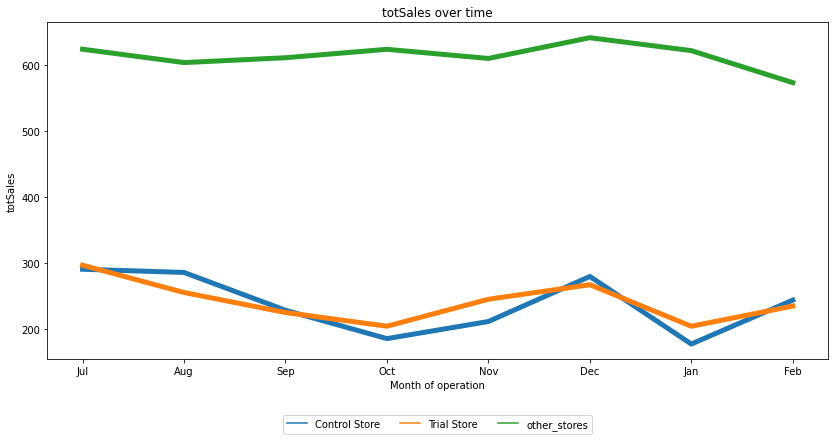

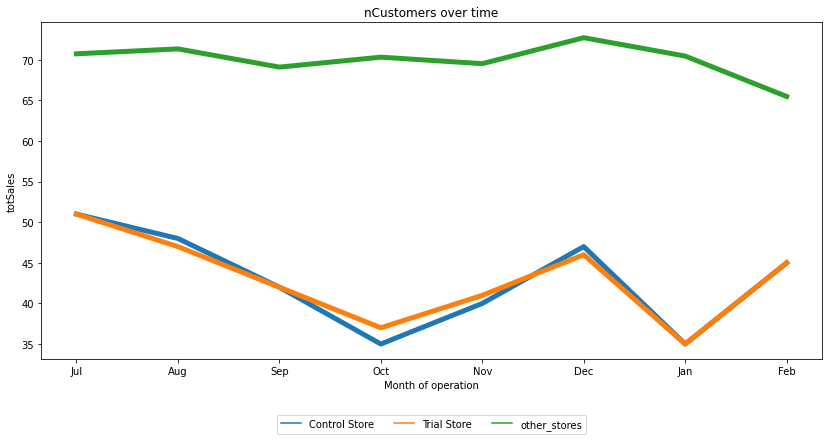

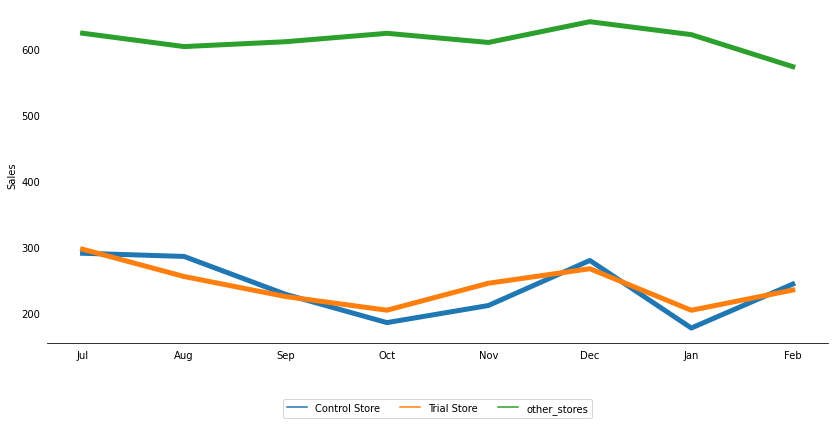

In [33]:
plottrends(233,77)

It is evident that the trial and control store have similar trends in terms of both total sales and number of customers, compared to the other stores. This comfirms that prior to the trial, they are similar.

__Assesse differences in total sales between trial store and control__


Conclusion: There is a statistically significant difference between trial and control stores during the trial period.


,STORE_NBR,YEARMONTH,percentageDiff,t-value,95th-percentile
7,77,2019-02,0.059107,1.278363,1.894579
8,77,2019-03,0.366521,7.927151,1.894579
9,77,2019-04,0.623080,13.476023,1.894579


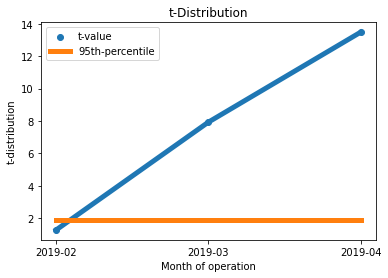

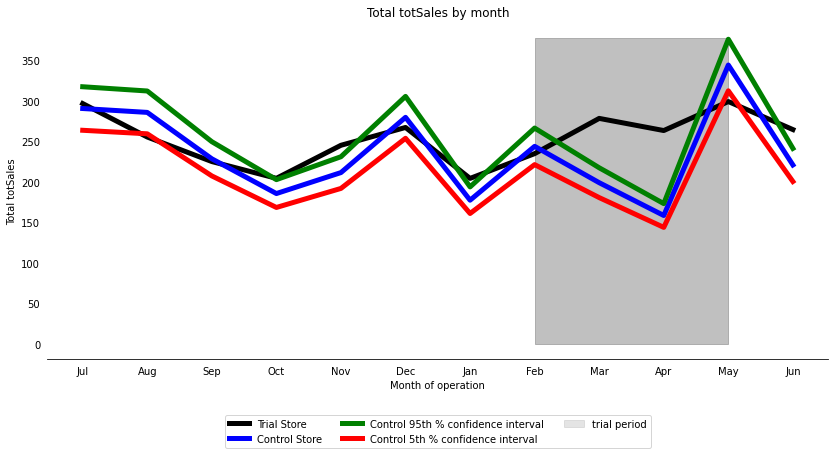

In [34]:
Analyse('totSales',233, 77)

We notice that the t-value for March and April is considerably higher than the 95th percentile value of the t-distribution. This implies that the growth in sales of the trial store in these two months is statistically more significant than the control store.

The findings suggest that there is a significant difference in the total sales of trial store 77 compared to its control store sales during the trial period, as the performance of the trial store falls beyond the 5% to 95% confidence interval of the control store for two out of the three trial months.

__Assesment for number of customers__


Conclusion: There is a statistically significant difference between trial and control stores during the trial period.


,STORE_NBR,YEARMONTH,percentageDiff,t-value,95th-percentile
7,77,2019-02,0.003344,0.198043,1.894579
8,77,2019-03,0.245819,14.556162,1.894579
9,77,2019-04,0.561427,33.244822,1.894579


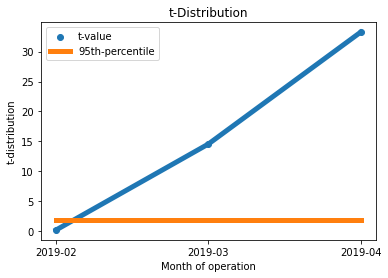

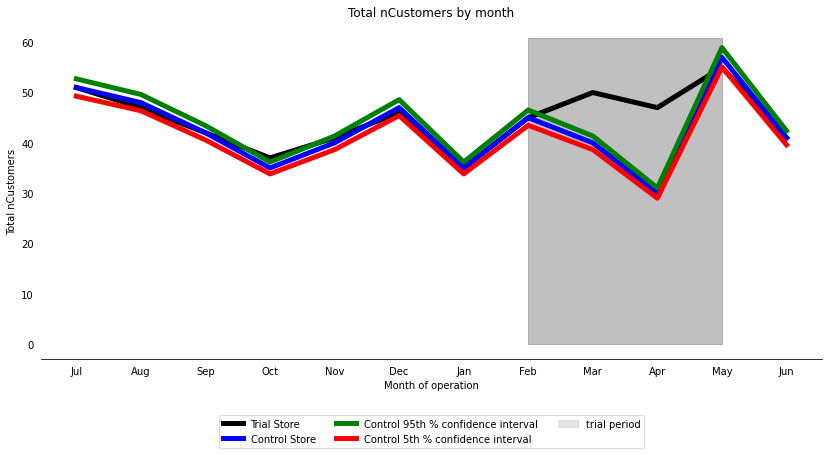

In [35]:
Analyse('nCustomers',233, 77)

The number of customers in trial store 77 during the trial period is significantly different from its control store as the trial store's performance is outside the 5% to 95% percentile of the t-distribution in two of the three trial months, just like the total sales. Therefore, it can be concluded that both the total sales and the number of customers in the trial and control stores are significantly different.

# __Trial store 86__

___Find control store for trial store 86___

In [36]:
findcontrol(86,'totSales','nCustomers')

Based on totSales and nCustomers drivers, the most appropriate control store 
for trial store 86 is 155.


___Check visually if the drivers are indeed similar in the period before the trial___

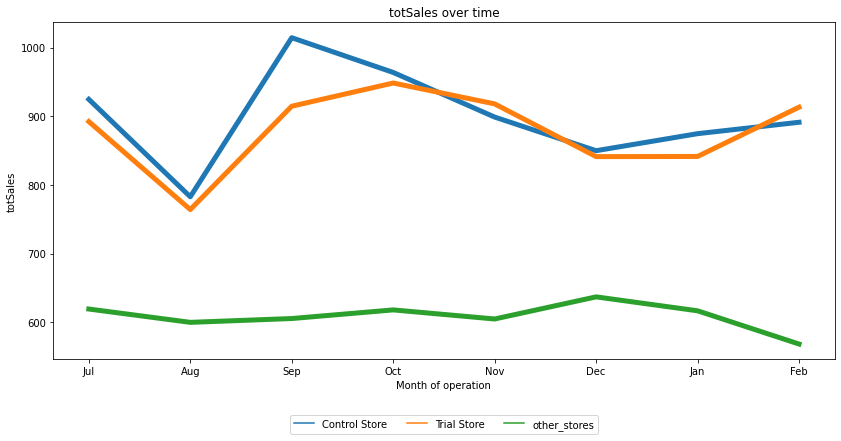

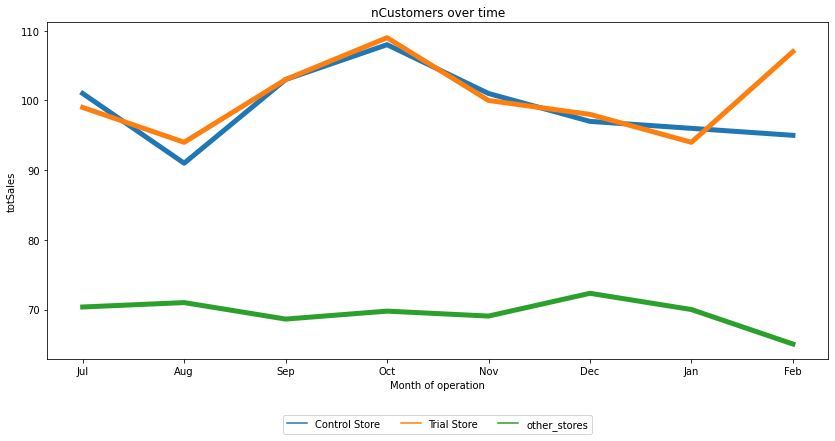

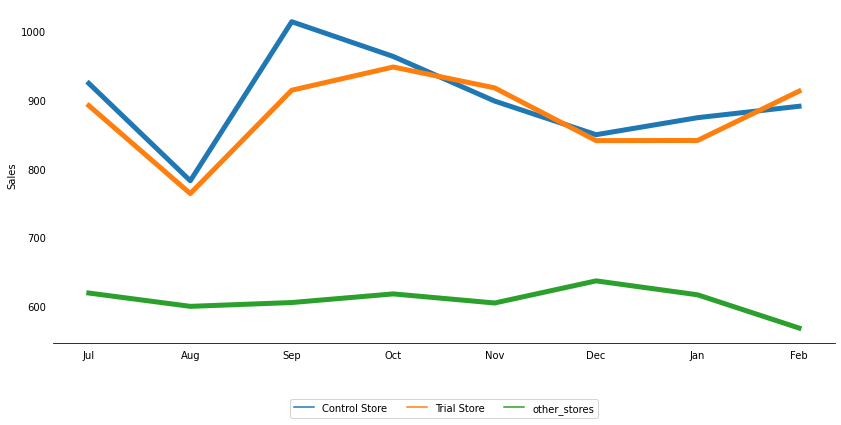

In [37]:
plottrends(155,86)

Again, it is evident that the trial and control stores have similar trends and are higher both in the total sales and number of customers, compared to the other stores.

__Assessment for totSales__


Conclusion: There is no statistically significant difference between trial and control stores during the trial period.


,STORE_NBR,YEARMONTH,percentageDiff,t-value,95th-percentile
7,86,2019-02,0.056306,2.354174,1.894579
8,86,2019-03,0.315870,13.206585,1.894579
9,86,2019-04,0.035253,1.473915,1.894579


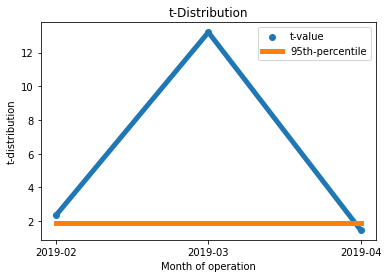

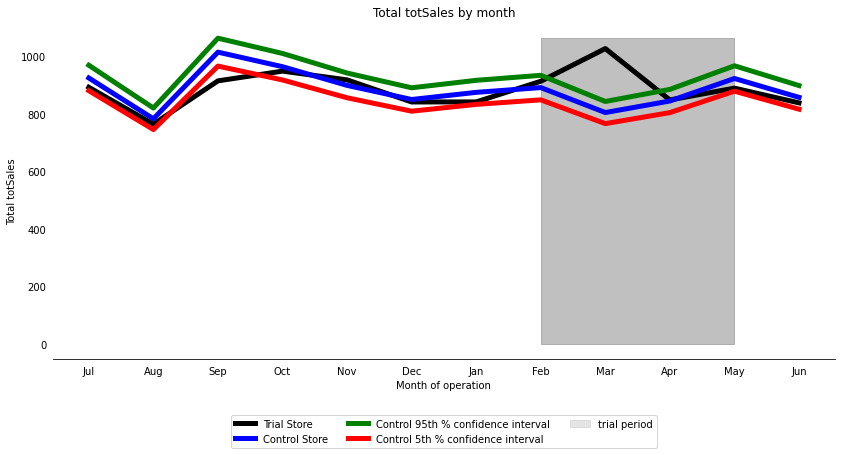

In [38]:
Analyse('totSales',155, 86)

Based on the results, it can be concluded that there is no significant difference between the trial store 86 and its control store during the trial period. This is because the performance of the trial store falls within the 5% to 95% confidence interval of the control store for two out of the three trial months.

__Assessment for nCustomers__


Conclusion: There is a statistically significant difference between trial and control stores during the trial period.


,STORE_NBR,YEARMONTH,percentageDiff,t-value,95th-percentile
7,86,2019-02,0.126316,12.766068,1.894579
8,86,2019-03,0.223404,22.578285,1.894579
9,86,2019-04,0.060606,6.125134,1.894579


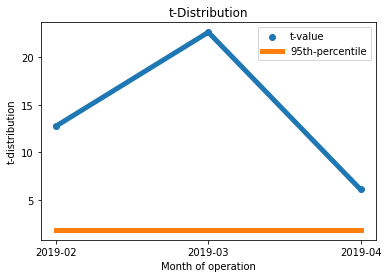

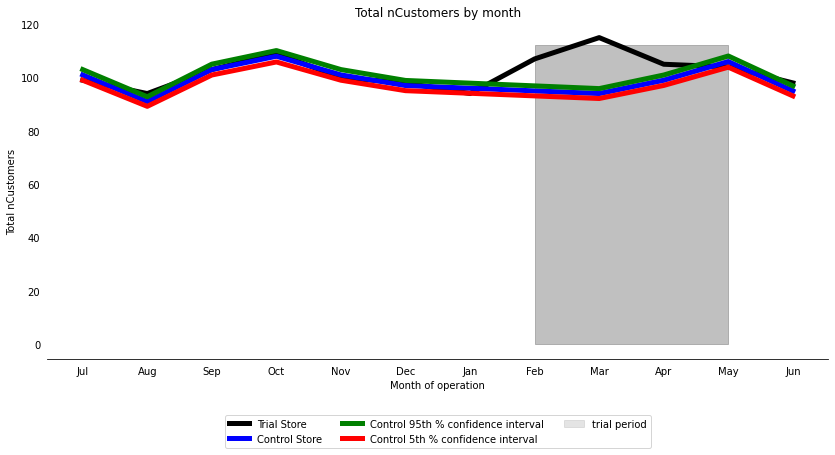

In [39]:
Analyse('nCustomers',155, 86)

It appears that there was a notable increase in the number of customers in all the three months, indicating that the trial had a substantial impact on the customer count at store 86. However, as previously mentioned, there was no significant increase in sales. To obtain a clear understanding, it would be appropriate to consult with the Category Manager to determine whether there were any exclusive deals or promotions in the trial store that might have drawn in more customers at the cost of lower sales.

# __Trial store 88__

___Find control store for trial store 88___

In [40]:
findcontrol(88, 'totSales','nCustomers')

Based on totSales and nCustomers drivers, the most appropriate control store 
for trial store 88 is 237.


___Check visually if the drivers are indeed similar in the period before the trial___

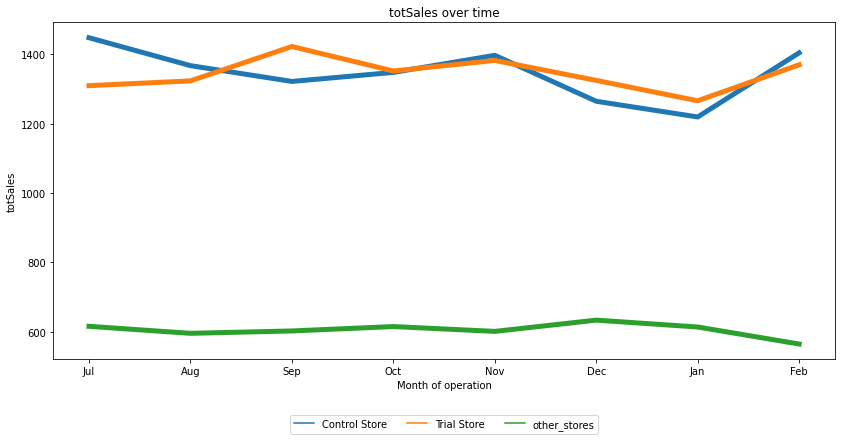

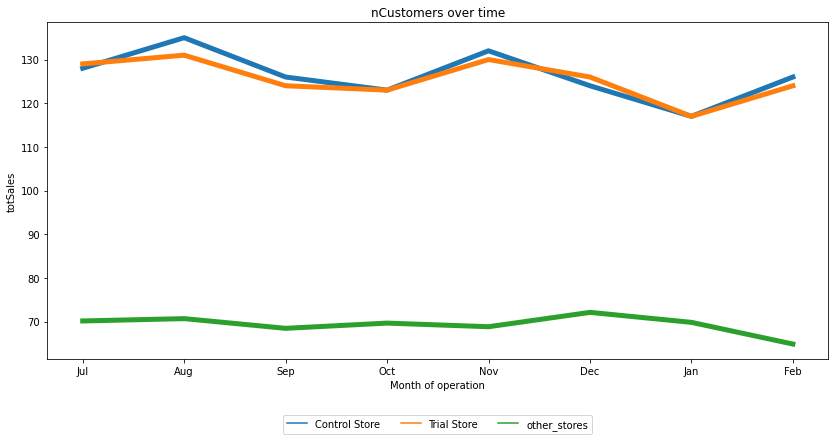

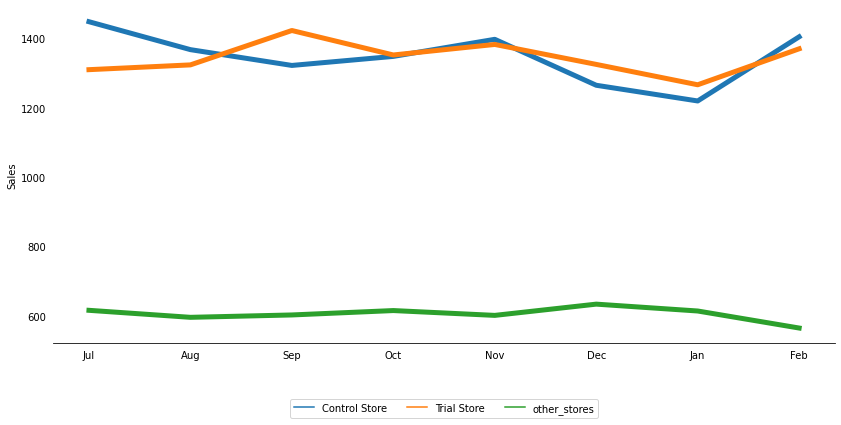

In [41]:
plottrends(237,88)

The trend of both total sales and number of customers are similar.

__Assessment for totSales__


Conclusion: There is a statistically significant difference between trial and control stores during the trial period.


,STORE_NBR,YEARMONTH,percentageDiff,t-value,95th-percentile
7,88,2019-02,0.026147,0.843868,1.894579
8,88,2019-03,0.220743,7.124136,1.894579
9,88,2019-04,0.193060,6.230721,1.894579


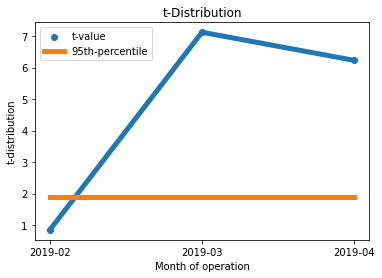

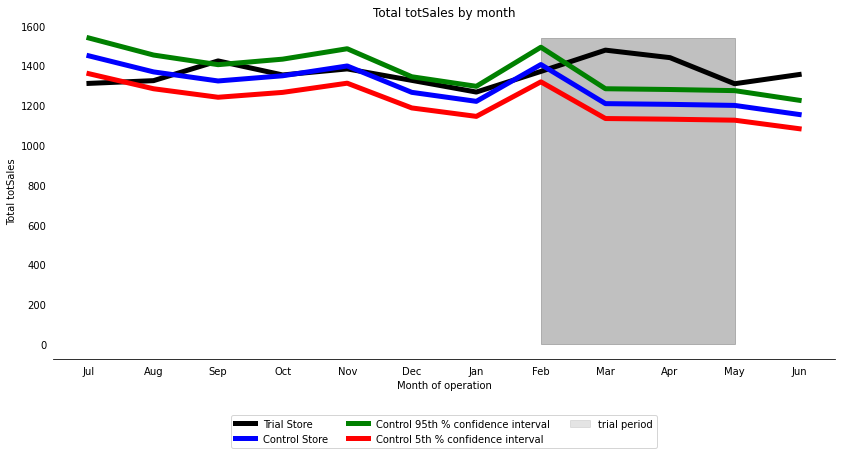

In [42]:
Analyse('totSales',237, 88)

The total sales in store 88 is significantly different to its control store in the trial period as the trial store performance lies above the 95% percentile t-distribution of the control store in two of the three trial months.

__Assessment for nCustomers__


Conclusion: There is a statistically significant difference between trial and control stores during the trial period.


,STORE_NBR,YEARMONTH,percentageDiff,t-value,95th-percentile
7,88,2019-02,0.010281,1.498623,1.894579
8,88,2019-03,0.132448,19.305795,1.894579
9,88,2019-04,0.072727,10.600788,1.894579


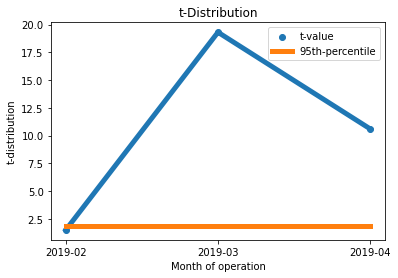

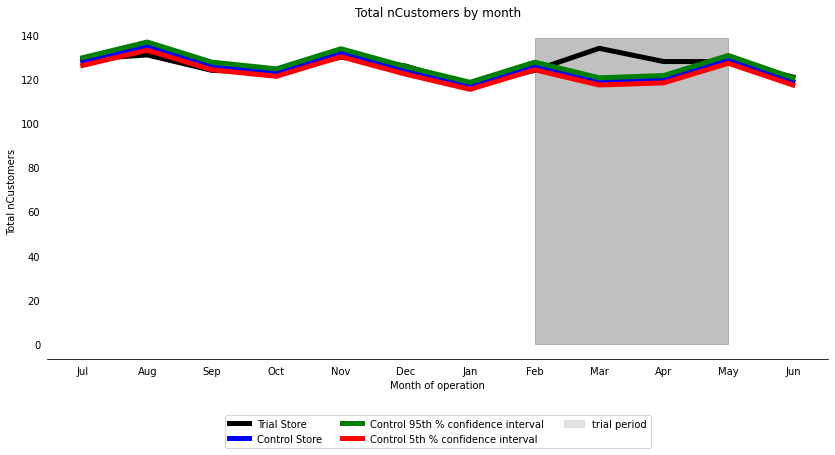

In [43]:
Analyse('nCustomers',237, 88)

The results show that the number of customers in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 95% percentile the t-distribution of the control store in two of the three trial months.

# __Conclusion__
 
 After identifying control stores 233, 155, and 178 for trial stores 77, 86, and 88 respectively, we found that there was a significant difference in at least two of the three trial months for trial stores 77 and 88, but not for trial store 86. It may be worth checking with the client if the trial implementation was different in store 86. Overall, the trial resulted in a significant increase in sales. With the analysis completed, I prepare an executive presentation for the Category Manager